In [2]:
import ipdb
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pylab as pylab
import cartopy
import cartopy.crs as ccrs
from utils import constants as cnst
from eod import msg
from utils import u_grid, u_interpolate as u_int, u_darrays as uda, u_met
import glob
import metpy
from metpy import calc
from metpy.units import units
from scipy import stats
import metpy
from metpy import calc
from metpy.units import units
import pickle as pkl

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
ml = 0.5
regions = {
'equatorial' : [(-5,0),(-78.25+ml, -73.75)],
'transition' : [(-8,-5), (-77.25+ml, -72.75)],
'central' : [(-12,-8), (-75.5+ml, -71.0)],
'southern' : [(-18,-15),  (-66.25+ml, -61.75)]}
h = 2000

In [4]:
topo_full = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/ERA5_static_hourly_0.25deg_peru.nc')
topo_full = uda.flip_lat(topo_full)

In [5]:
height = xr.open_dataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/topo_ERA5_peru.nc')['h']


In [6]:
def readERA_hourly(tag='surface'):
    
    print('Opening', glob.glob('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/'+tag+'/ERA5_*.nc')[0])
    u200orig = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/peru/'+tag+'/ERA5_*.nc')
    u200orig = uda.flip_lat(u200orig)
#     datetimes = pd.to_datetime(u200orig.time.values)
#     newtimes = []
#     for t in datetimes:
#         newtimes.append(t.replace(hour=0))
#     u200orig['time'] = ('time', newtimes)
    return u200orig

In [7]:
pl = readERA_hourly(tag='pressure_levels')

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/pressure_levels/ERA5_1979_01_01_pl.nc


In [8]:
reg_tag = 'transition'
alls = regions[reg_tag]
pl_mean = pl.sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(alls[1][0], alls[1][1])).mean(['longitude','latitude'])

In [9]:
srfc = readERA_hourly(tag='surface')

Opening /media/ck/Elements/SouthAmerica/ERA5/hourly/peru/surface/ERA5_1979_01_01_srfc.nc


In [10]:
reg_tag = 'transition'
alls = regions[reg_tag]
srfc_mean = srfc.sel(latitude=slice(alls[0][0], alls[0][1]), longitude=slice(alls[1][0], alls[1][1])).mean(['longitude','latitude'])

In [11]:
srfc_mean = srfc_mean.isel(expver=0)

In [13]:
pl_mean

<xarray.Dataset>
Dimensions:  (level: 17, time: 123624)
Coordinates:
  * level    (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
  * time     (time) datetime64[ns] 1979-01-01 ... 2021-04-25T21:00:00
Data variables:
    d        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    z        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    pv       (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    r        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    q        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    t        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    u        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    v        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>
    w        (time, level) float32 dask.array<chunksize=(8, 17), meta=np.ndarray>

In [14]:
def apply_drywet_hourly(ds, region, spell=3, minus='0days', plus='0days', area=0.2):
    dwspells = pkl.load(open("/home/ck/DIR/cornkle/data/HUARAZ/saves/"+region+"_dw_spellDates_"+str(area)+"perc_v2.p", "rb"))
    
    dds = dwspells['dry'+str(spell)]
    wds = dwspells['wet'+str(spell)]
    
    dw_3h = []
    for dw in wds:
        for ho in np.arange(0,24,3):
            dw_3h.append(dw.replace(hour=ho))
    dw_3h = pd.to_datetime(dw_3h)
    
    dd_3h = []
    for dw in dds:
        for ho in np.arange(0,24,3):
            dd_3h.append(dw.replace(hour=ho))
    dd_3h = pd.to_datetime(dd_3h)

    dds = dd_3h -pd.Timedelta(minus) + pd.Timedelta(plus)
    wds = dw_3h -pd.Timedelta(minus) + pd.Timedelta(plus)
    
    print('dry', len(dds), 'wet', len(wds))
    xy, x_ind, y_ind  = np.intersect1d(dds, ds.time, return_indices=True)
    dds = dds[x_ind]
    
    xy, x_ind, y_ind  = np.intersect1d(wds, ds.time, return_indices=True)
    wds = wds[x_ind]
    print('dry2', len(dds), 'wet2', len(wds))
    
    
   # ipdb.set_trace()

    mean_dry = ds.sel(time=dds).groupby('time.hour').mean('time')
    mean_wet = ds.sel(time=wds).groupby('time.hour').mean('time')

    
#     outdic = {'dry' : mean_dry,
#               'wet' : mean_wet,
#              }

    return mean_wet#.load()

In [15]:
series_pl = {}

for dv in pl_mean.data_vars:
#     if dv not in ['cape', 'tcwv', 'cin', 'sp', 'tciw', 'msshf', 'mtpr', 'p84.162']:
#         continue
    series_pl[dv] = []

spelldays=5
ar = 0.15


for num in np.arange(0,5)[::-1]:
    for dv in series_pl.keys():
        series_pl[dv].extend(apply_drywet_hourly(pl_mean[dv], reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    for dv in series_pl.keys():
        series_pl[dv].extend(apply_drywet_hourly(pl_mean[dv], reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet

In [16]:
series_pl

{'d': [<xarray.DataArray 'd' (level: 17)>
  dask.array<getitem, shape=(17,), dtype=float32, chunksize=(17,), chunktype=numpy.ndarray>
  Coordinates:
    * level    (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
      hour     int64 0,
  <xarray.DataArray 'd' (level: 17)>
  dask.array<getitem, shape=(17,), dtype=float32, chunksize=(17,), chunktype=numpy.ndarray>
  Coordinates:
    * level    (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
      hour     int64 3,
  <xarray.DataArray 'd' (level: 17)>
  dask.array<getitem, shape=(17,), dtype=float32, chunksize=(17,), chunktype=numpy.ndarray>
  Coordinates:
    * level    (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
      hour     int64 6,
  <xarray.DataArray 'd' (level: 17)>
  dask.array<getitem, shape=(17,), dtype=float32, chunksize=(17,), chunktype=numpy.ndarray>
  Coordinates:
    * level    (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
      hour     int64 9,

In [17]:
for var in series_pl.keys():
    print('Doing ', var)
    if 'd' in var:
        continue
    xr.concat(series_pl[var],'times').load().to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+str(var)+'_'+reg_tag+'_wetdat_timeseries_pl.nc')

Doing  d
Doing  z
Doing  pv
Doing  r
Doing  q
Doing  t
Doing  u
Doing  v
Doing  w


In [19]:
series_srfc = {}

for dv in srfc_mean.data_vars:
    if dv not in ['cape', 'tcwv', 'cin', 'sp', 'tciw', 'msshf', 'mtpr', 'p84.162']:
        continue
    series_srfc[dv] = []

spelldays=5
ar = 0.15


for num in np.arange(0,5)[::-1]:
    for dv in series_srfc.keys():
        series_srfc[dv].extend(apply_drywet_hourly(srfc_mean[dv], reg_tag, spell=spelldays, minus=str(num)+'days', plus='0days', area=ar))
for num in np.arange(1,6):
    for dv in series_srfc.keys():
        series_srfc[dv].extend(apply_drywet_hourly(srfc_mean[dv], reg_tag, spell=spelldays, minus='0days', plus=str(num)+'days', area=ar))

dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5200
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5184
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet 5200
dry2 8016 wet2 5192
dry 8016 wet

In [1]:
for var in series_srfc.keys():
    xr.concat(series_srfc[var],'times').to_netcdf('/media/ck/Elements/SouthAmerica/ERA5/hourly/'+str(var)+'_'+reg_tag+'_wetdat_timeseries.nc')

NameError: name 'series_srfc' is not defined

In [84]:
qup_l = []
qlow_l =[]
d_l = []
v_l = []
u_l = []
t_l = []
tcw_l = []
cape_l = []


################################################
for rr in ['central', 'equatorial', 'southern']:
    srf = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/*_'+rr+'*_timeseries.nc')
    pll = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/*_'+rr+'*_timeseries_pl.nc')
    
    qup_l.append(pll['q'].sel(level=650))
    qlow_l.append(pll['q'].sel(level=850))
    d_l.append(pll['d'].sel(level=850))
    v_l.append(pll['v'].sel(level=850))
    u_l.append(pll['u'].sel(level=200))
    t_l.append(pll['t'].sel(level=850))
    tcw_l.append(srf['tcwv'])
    cape_l.append(srf['cape'])
    
    
    

In [85]:
len(cape_l)

3

In [6]:
rr = 'central'
srf = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/*_'+rr+'*_timeseries.nc')
pll = xr.open_mfdataset('/media/ck/Elements/SouthAmerica/ERA5/hourly/*_'+rr+'*_timeseries_pl.nc')

In [7]:
pll

<xarray.Dataset>
Dimensions:  (level: 17, times: 80)
Coordinates:
  * level    (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
    hour     (times) int64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: times
Data variables:
    pv       (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    q        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    r        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    t        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    u        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    v        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    w        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    z        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


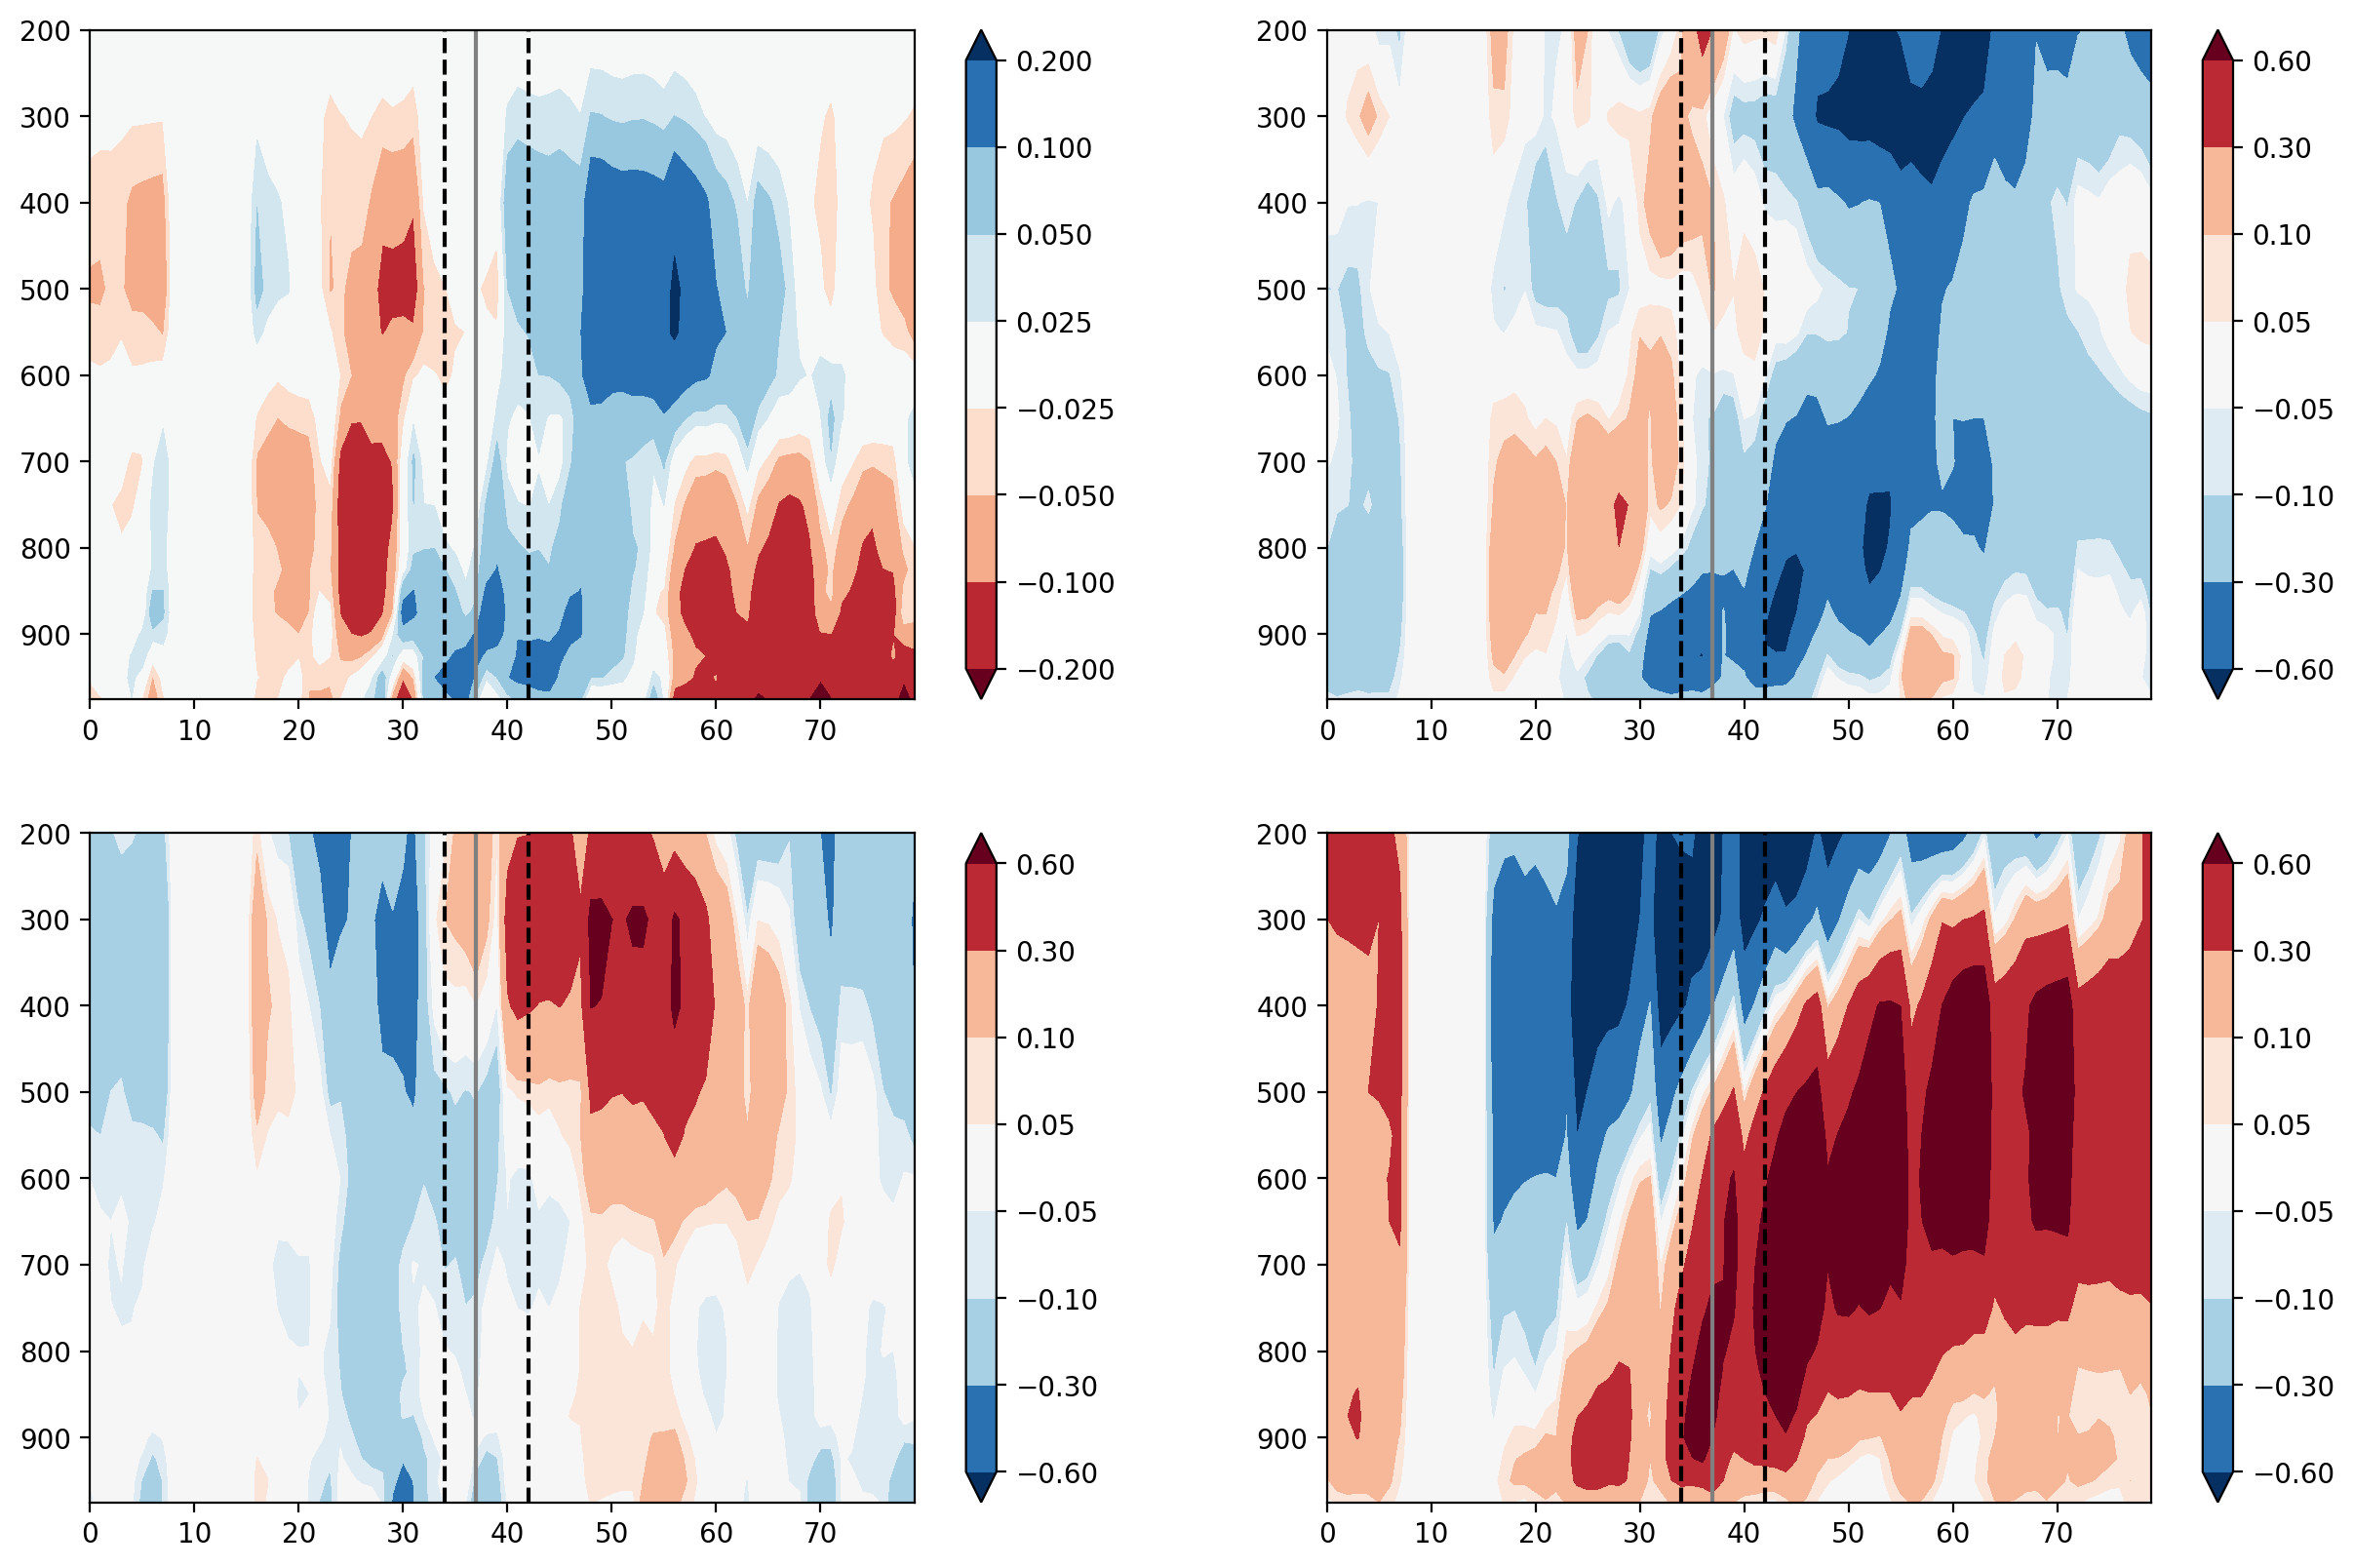

In [8]:
f=plt.figure(figsize=(15,10), dpi=200)
ax = f.add_subplot(221)
mp = plt.contourf(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0+8,8+8)).swap_dims({'times':'hour'}))*1000).T, cmap='RdBu', levels=[-0.2,-0.1,-0.05, -0.025, 0.025, 0.05,0.1,0.2], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['v'].groupby('hour')-pll['v'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=np.linspace(-1,1,10), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

ax = f.add_subplot(222)
mp = plt.contourf(pll.times, pll.level, ((pll['v'].groupby('hour')-pll['v'].isel(times=slice(0+8,8+8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')


ax = f.add_subplot(223)
mp = plt.contourf(pll.times, pll.level, ((pll['r'].groupby('hour')-pll['r'].isel(times=slice(0+8,8+8)).swap_dims({'times':'hour'}))/10).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

ax = f.add_subplot(224)
mp = plt.contourf(pll.times, pll.level, ((pll['u'].groupby('hour')-pll['u'].isel(times=slice(0+8,8+8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


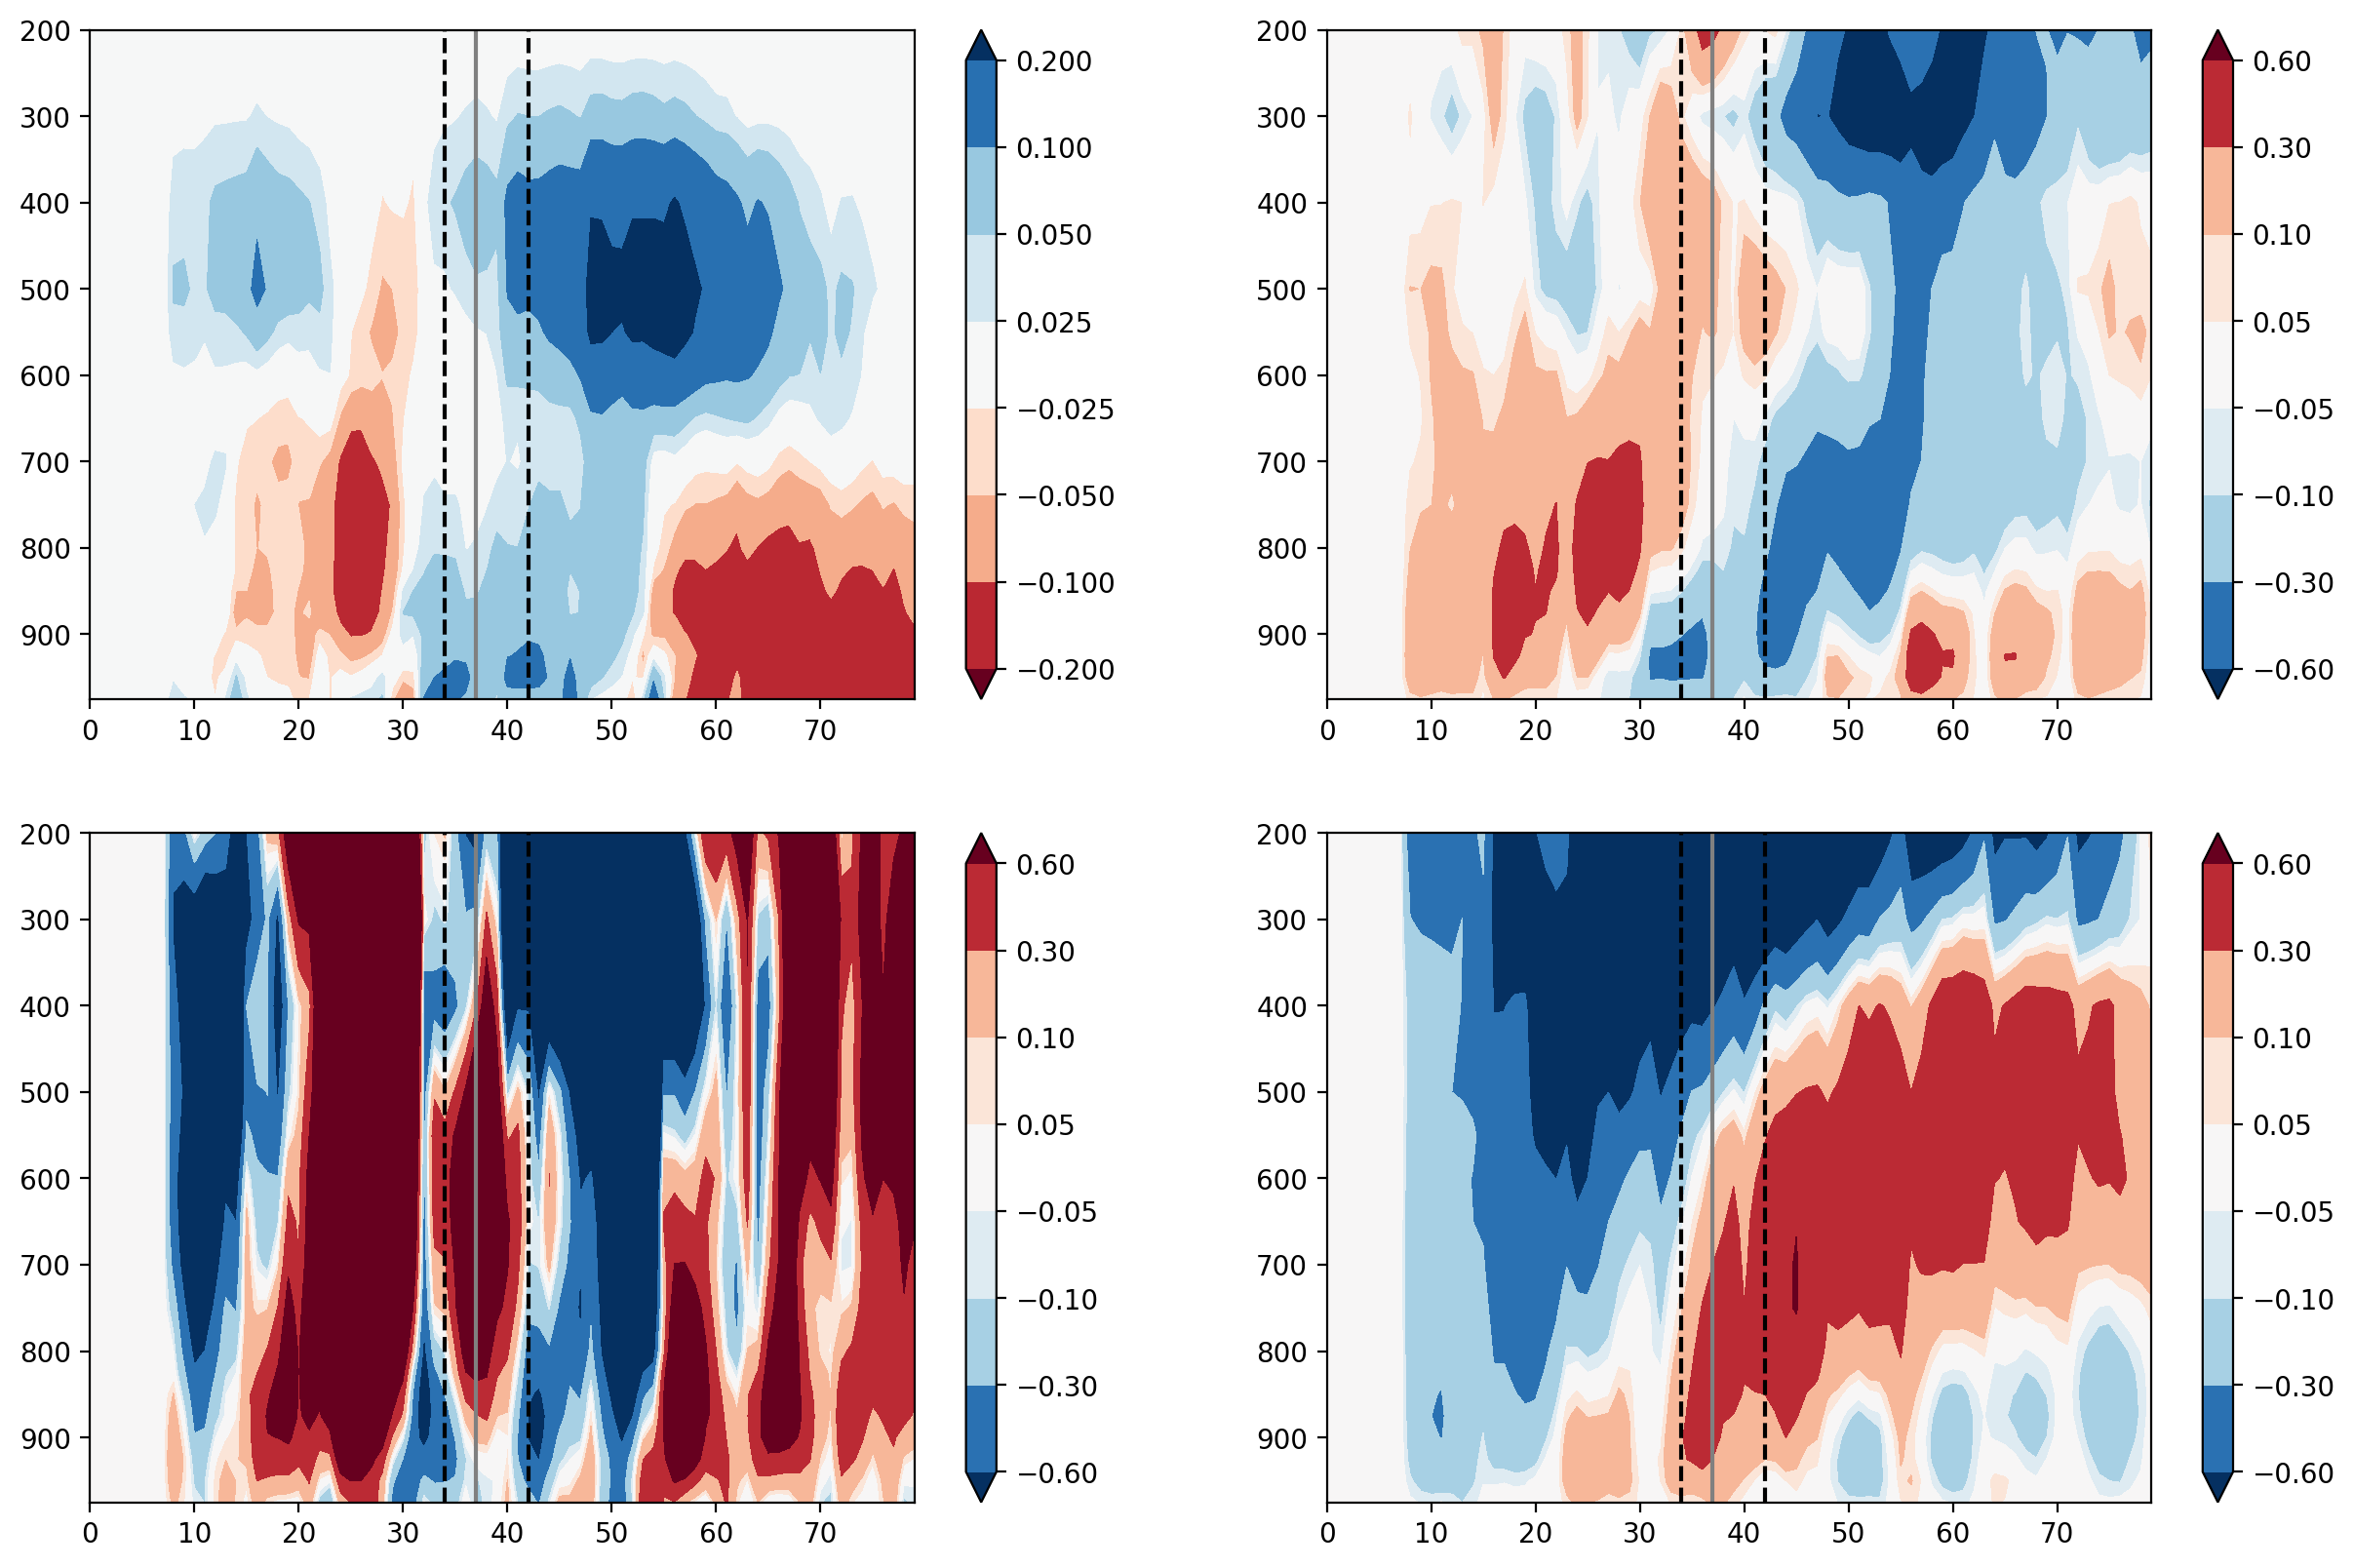

In [11]:
f=plt.figure(figsize=(15,10), dpi=200)
ax = f.add_subplot(221)
mp = plt.contourf(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))*1000).T, cmap='RdBu', levels=[-0.2,-0.1,-0.05, -0.025, 0.025, 0.05,0.1,0.2], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['v'].groupby('hour')-pll['v'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=np.linspace(-1,1,10), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

ax = f.add_subplot(222)
mp = plt.contourf(pll.times, pll.level, ((pll['v'].groupby('hour')-pll['v'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')


ax = f.add_subplot(223)
mp = plt.contourf(pll.times, pll.level, ((pll['w'].groupby('hour')-pll['w'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))*100).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

ax = f.add_subplot(224)
mp = plt.contourf(pll.times, pll.level, ((pll['u'].groupby('hour')-pll['u'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


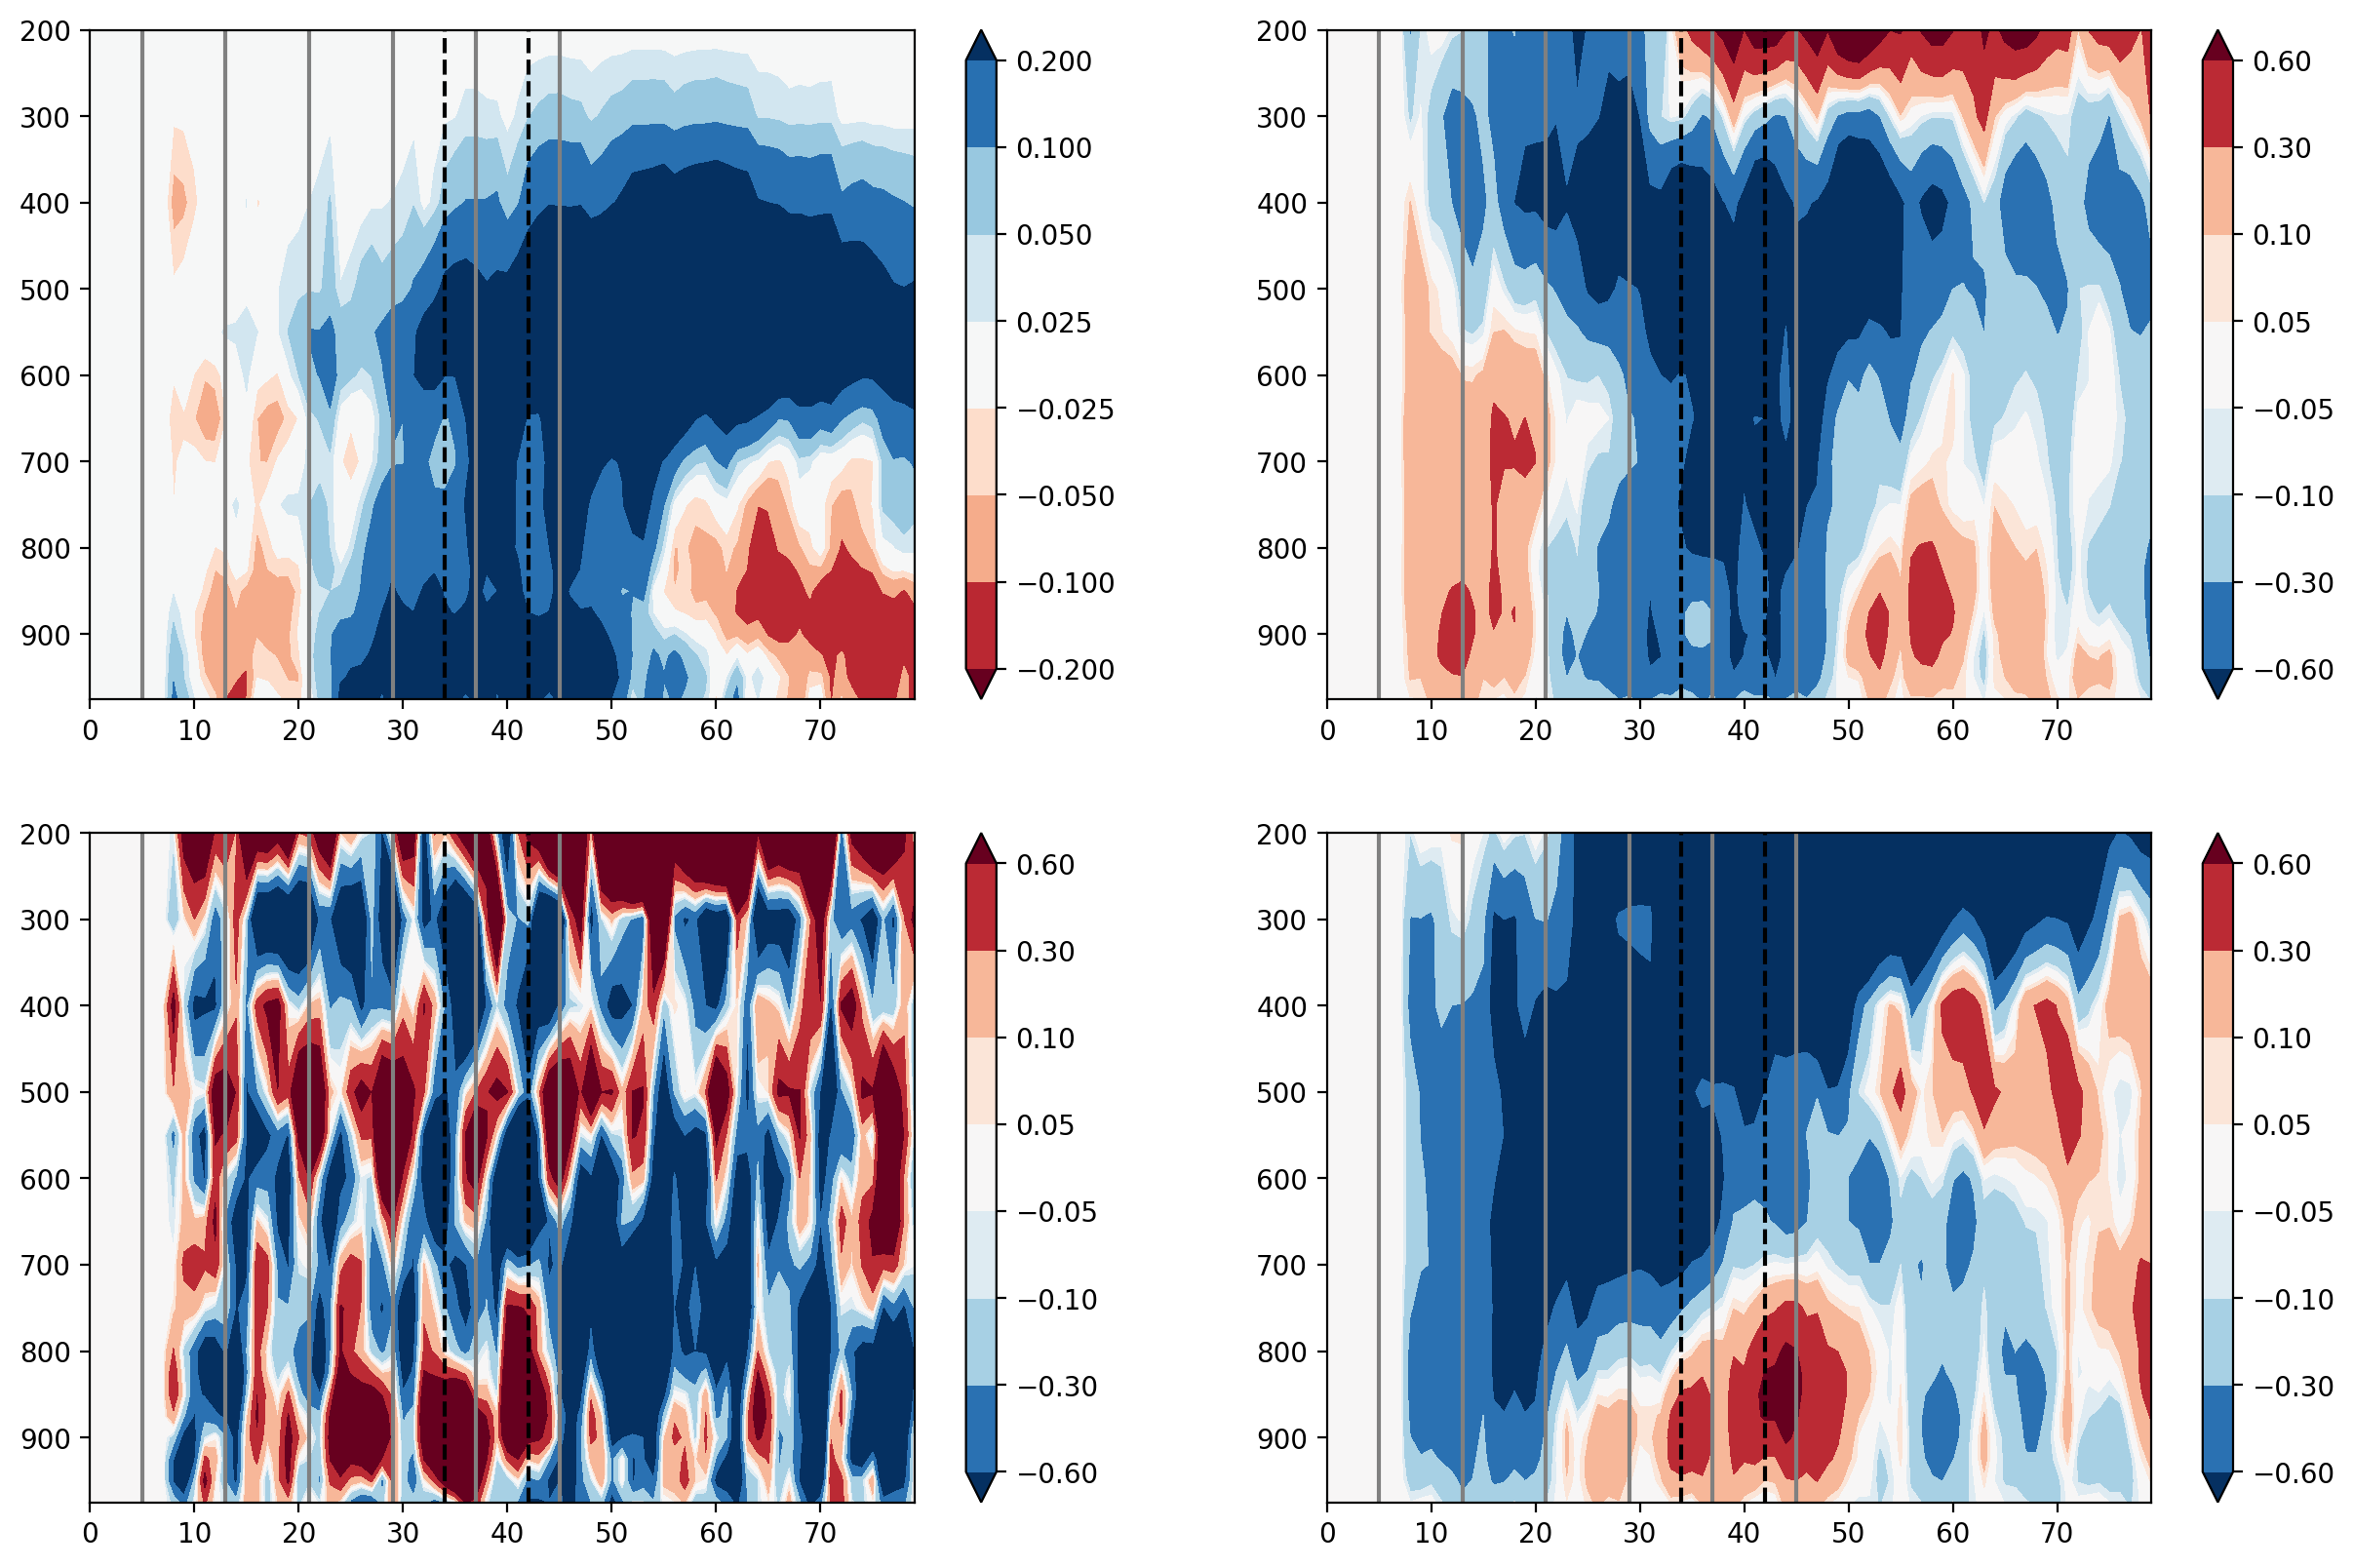

In [13]:
f=plt.figure(figsize=(15,10), dpi=200)
ax = f.add_subplot(221)
mp = plt.contourf(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))*1000).T, cmap='RdBu', levels=[-0.2,-0.1,-0.05, -0.025, 0.025, 0.05,0.1,0.2], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['v'].groupby('hour')-pll['v'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=np.linspace(-1,1,10), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
for lo in np.arange(6):
    ax.axvline(lo*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

ax = f.add_subplot(222)
mp = plt.contourf(pll.times, pll.level, ((pll['v'].groupby('hour')-pll['v'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
for lo in np.arange(6):
    ax.axvline(lo*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')


ax = f.add_subplot(223)
mp = plt.contourf(pll.times, pll.level, ((pll['d'].groupby('hour')-pll['d'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))*1000000).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
for lo in np.arange(6):
    ax.axvline(lo*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

ax = f.add_subplot(224)
mp = plt.contourf(pll.times, pll.level, ((pll['u'].groupby('hour')-pll['u'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T, cmap='RdBu_r', levels=[-0.6, -0.3,-0.1,-0.05, 0.05,0.1,0.3,0.6], extend='both')
#mp = plt.contour(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))).T*10000, cmap='RdBu_r', levels=np.linspace(-1,1,0.25), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
for lo in np.arange(6):
    ax.axvline(lo*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


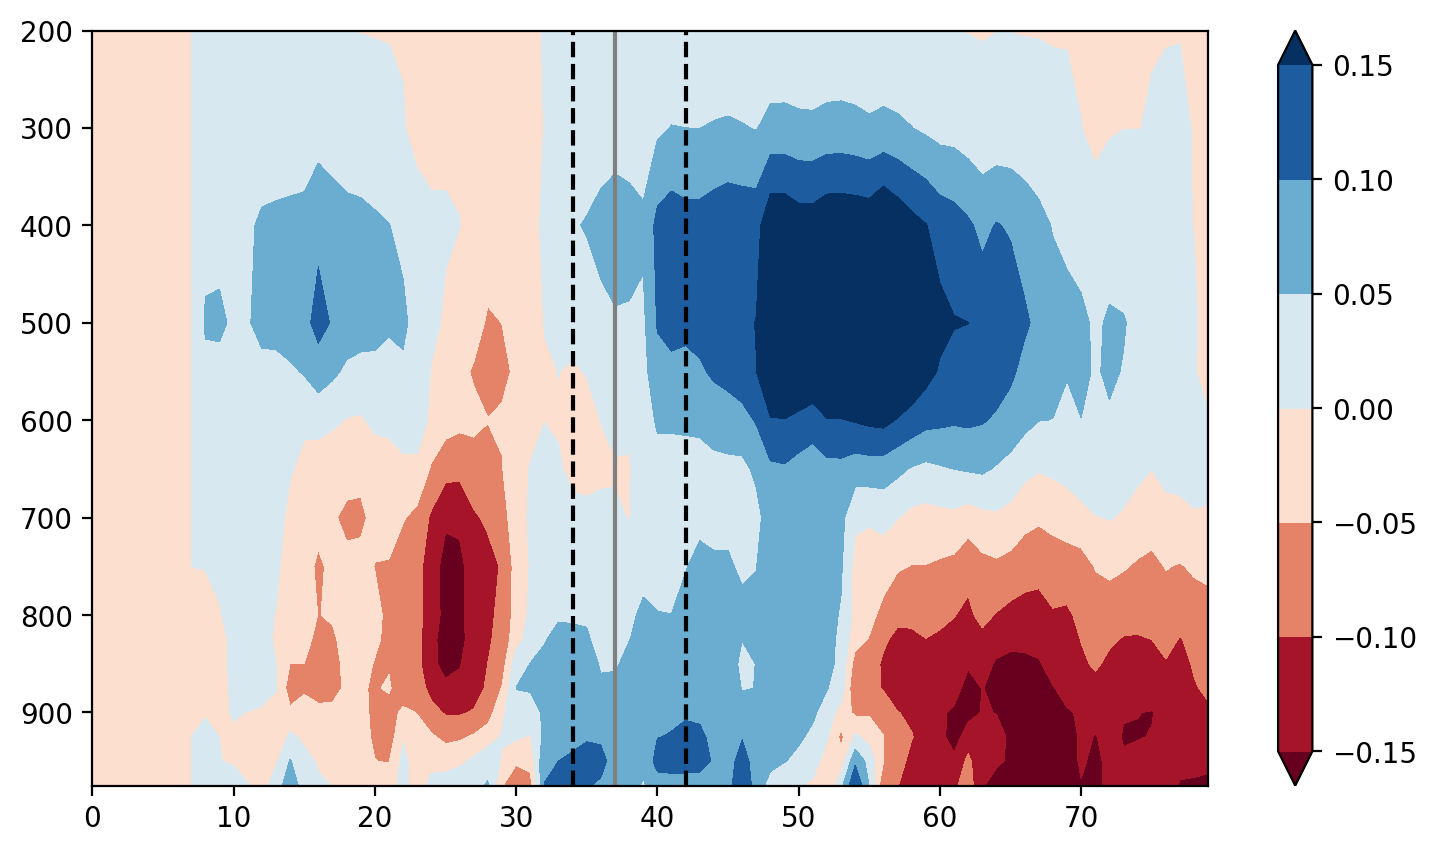

In [43]:
f=plt.figure(figsize=(9,5), dpi=200)
ax = f.add_subplot(111)
mp = plt.contourf(pll.times, pll.level, ((pll['q'].groupby('hour')-pll['q'].isel(times=slice(0,8)).swap_dims({'times':'hour'}))*1000).T, cmap='RdBu', levels=np.arange(-0.15,0.16,0.05), extend='both')
plt.colorbar(mp)
ax.invert_yaxis()
ax.axvline(4*8+5, color='grey')
ax.axvline(4*8+2, color='k', linestyle='dashed')
ax.axvline(5*8+2, color='k', linestyle='dashed')

In [56]:
pll

<xarray.Dataset>
Dimensions:  (level: 17, times: 80)
Coordinates:
  * level    (level) int32 200 300 400 500 550 600 ... 850 875 900 925 950 975
    hour     (times) int64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: times
Data variables:
    d        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    pv       (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    q        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    r        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    t        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    u        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    v        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    w        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>
    z        (times, level) float32 dask.array<chunksize=(80, 17), meta=np.ndarray>

In [60]:
cape = srf['cape']
cin = srf['cin']
precip = srf['mtpr']
ice = srf['tciw']
tcwv = srf['tcwv']
sp = srf['sp']

In [114]:
# qup_l = []
# qlow_l =[]
# d_l = []
# v_l = []
# u_l = []
# t_l = []
# tcw_l = []
# cape_l = []

/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/site-packages/xarray/core/indexing.py:1361: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]
/home/ck/miniconda3/lib/python3.7/s

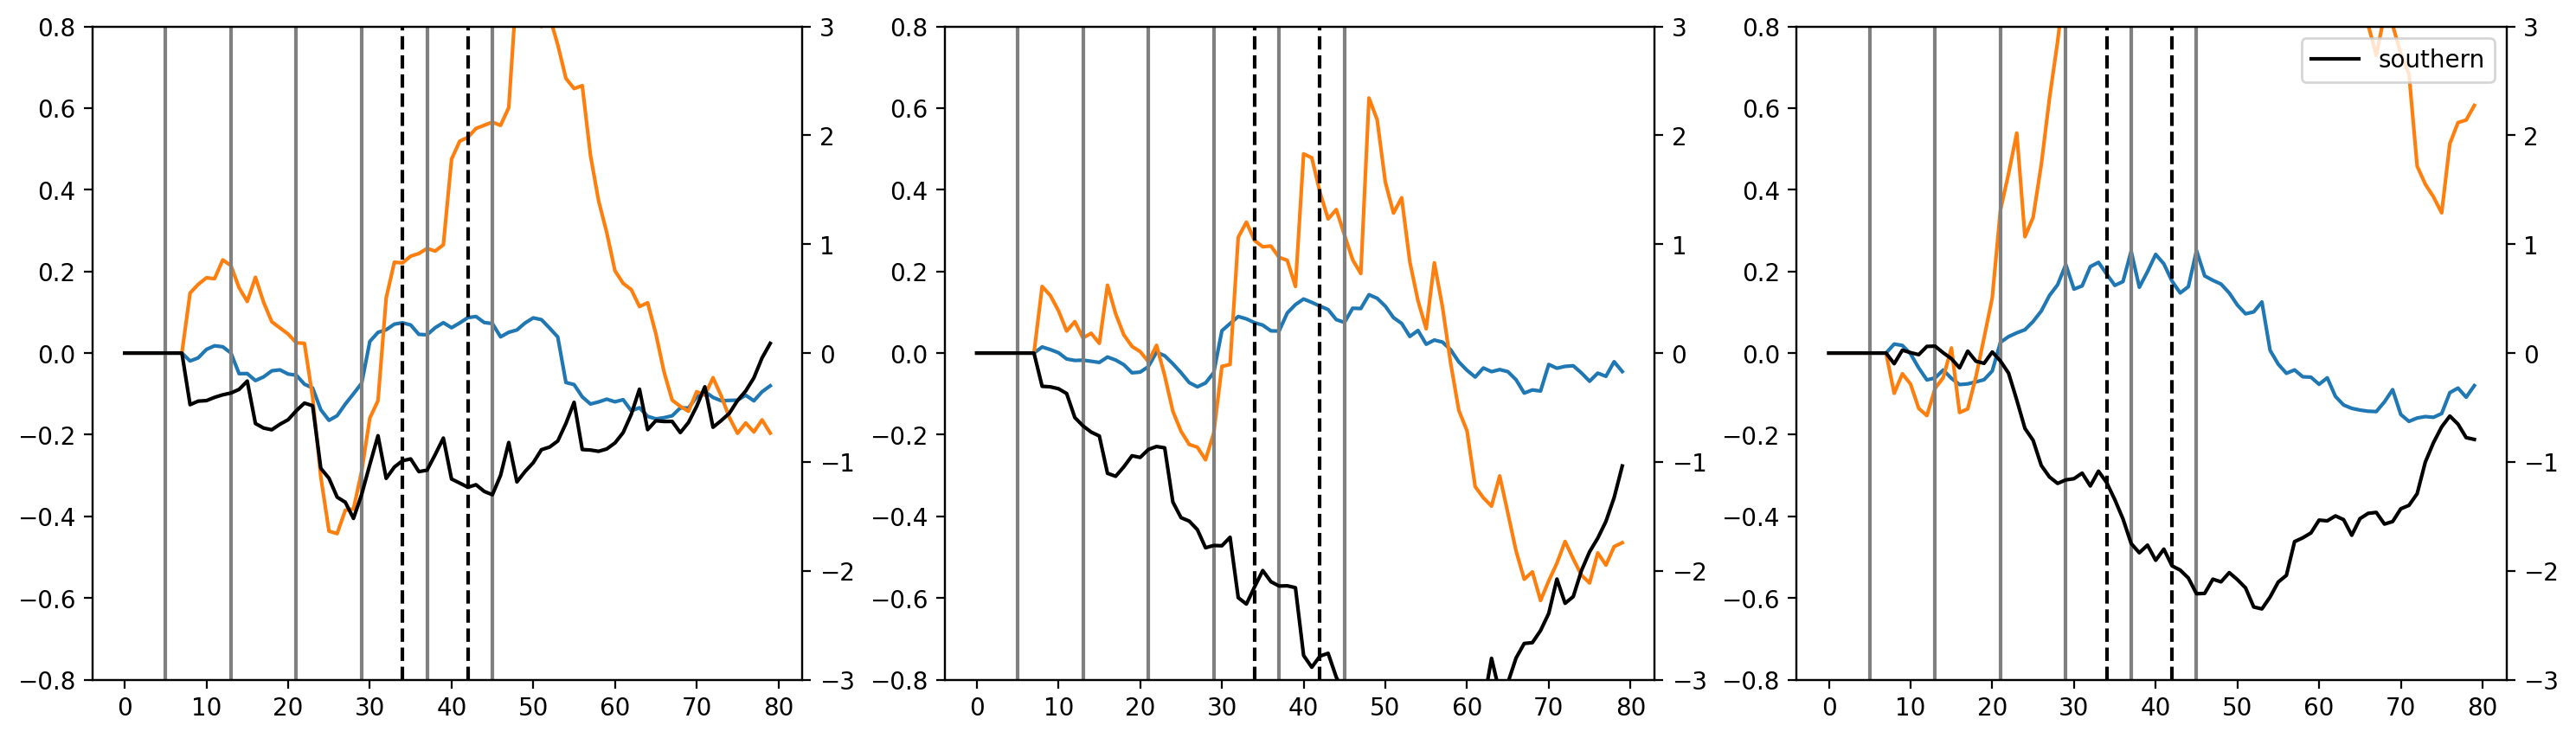

In [143]:
regtag = ['equatorial', 'central', 'southern']
f = plt.figure(figsize=(18,5), dpi=200)

for ids, ps in enumerate(qlow_l):
    ax = f.add_subplot(1,3,ids+1)
    
    tc = tcw_l[ids]
    uw = u_l[ids]
    
    ax.plot((ps.groupby('hour')-ps.isel(times=slice(0,8)).swap_dims({'times':'hour'})).values*1000, label=regtag[ids])
    ax.plot((tc.groupby('hour')-tc.isel(times=slice(0,8)).swap_dims({'times':'hour'})).values, label=regtag[ids])
    ax2 = ax.twinx()
    ax2.plot((uw.groupby('hour')-uw.isel(times=slice(0,8)).swap_dims({'times':'hour'})).values, label=regtag[ids], color='k')
    
    #ax.axvline(4*8+5, color='grey')
    for lo in np.arange(6):
        ax.axvline(lo*8+5, color='grey')
    ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(5*8+2, color='k', linestyle='dashed')

    ax.set_ylim(-0.8,0.8)
    ax2.set_ylim(-3,3)
plt.legend()

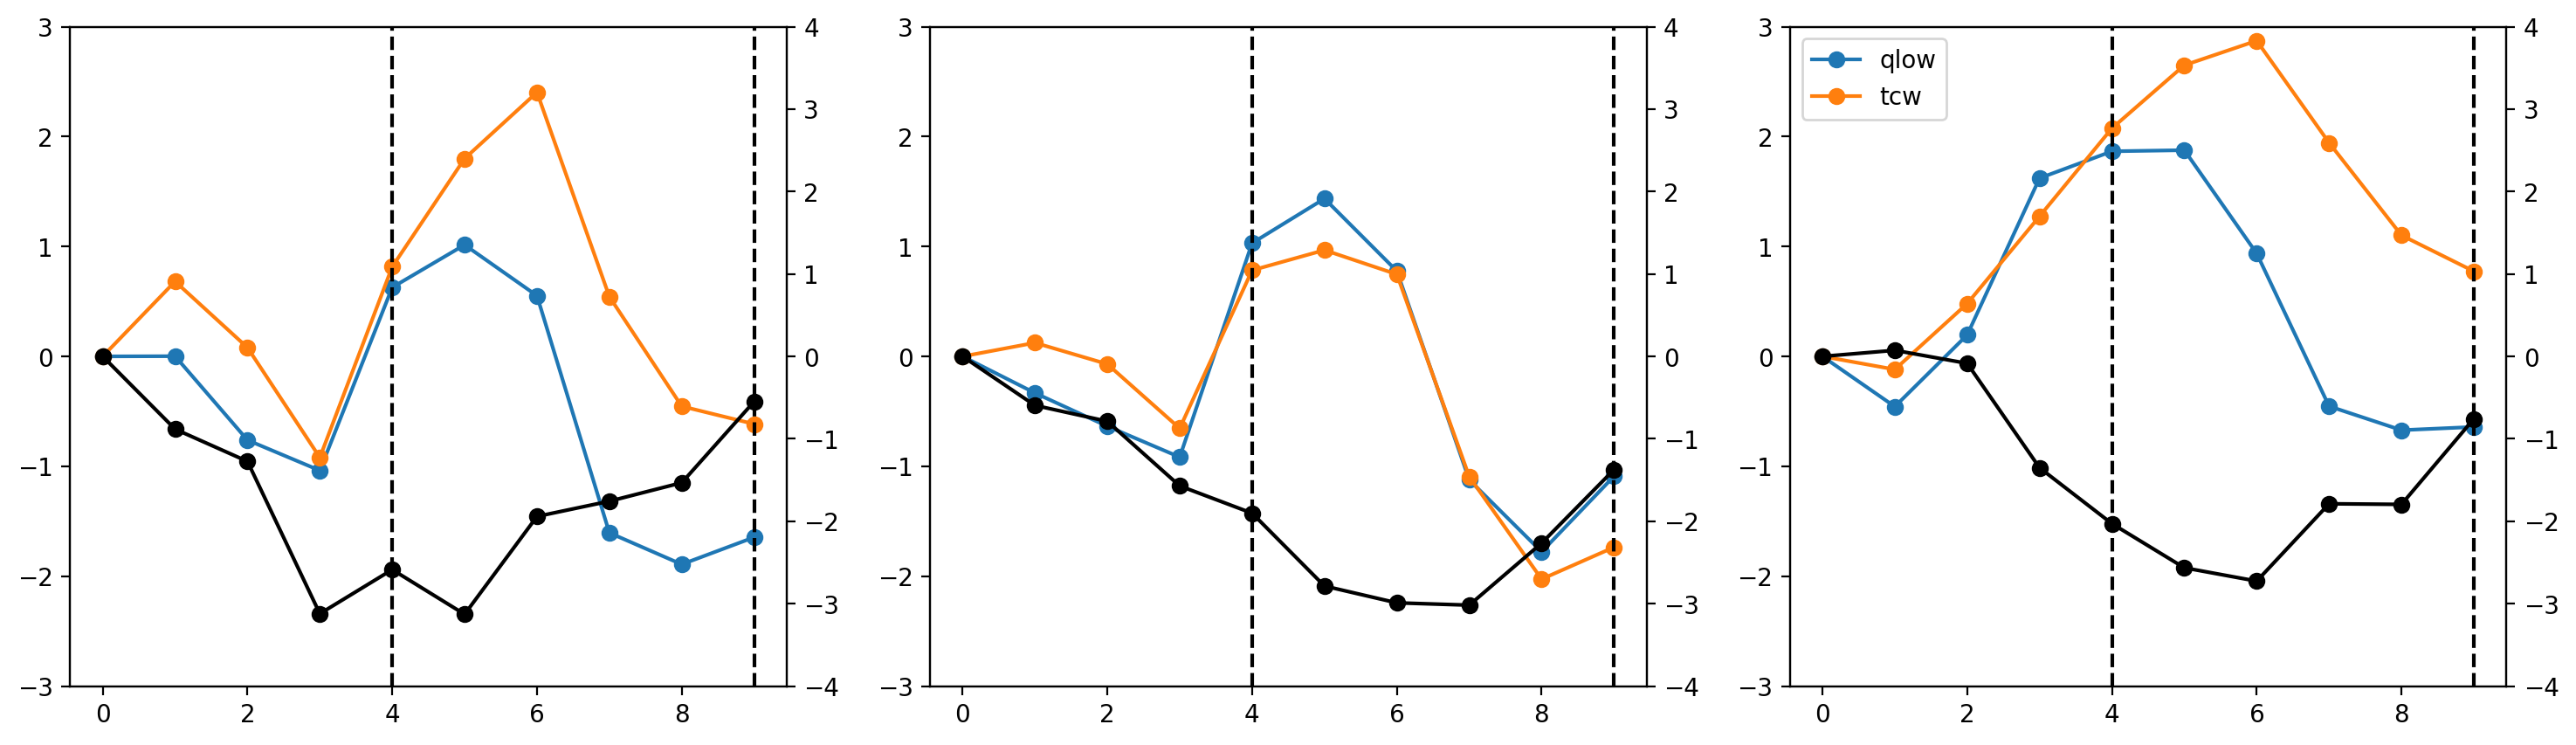

In [161]:
regtag = ['equatorial', 'central', 'southern']
f = plt.figure(figsize=(18,5), dpi=200)

ind = 8+5

for ids, ps in enumerate(qlow_l):
    ax = f.add_subplot(1,3,ids+1)
    
    tc = tcw_l[ids]
    uw = u_l[ids]
    
    ax.plot(np.arange(len(uw[5::8])),(ps[5::8]-ps.isel(times=5)).values/ np.std((ps[5::8]-ps.isel(times=5)).values),  label='qlow', marker='o')
    ax.plot(np.arange(len(uw[5::8])),(tc[5::8]-tc.isel(times=5)).values/ np.std((tc[5::8]-tc.isel(times=5)).values), label='tcw', marker='o')
    ax2 = ax.twinx()
    ax2.plot(np.arange(len(uw[5::8])),(uw[5::8]-uw.isel(times=5)).values/ np.std((uw[5::8]-uw.isel(times=5)).values), color='k', marker='o')
    
#     ax.axvline(4*8+5, color='grey')
#     ax.axvline(4*8+2, color='k', linestyle='dashed')
    ax.axvline(4, color='k', linestyle='dashed')
    ax.axvline(4+5, color='k', linestyle='dashed')

    ax.set_ylim(-3,3)
    ax2.set_ylim(-4,4)
ax.legend()

In [135]:
np.arange(len(uw[2*8+5::8]))

array([0, 1, 2, 3, 4, 5, 6, 7])

In [143]:
u

<xarray.DataArray 'u' (times: 80)>
array([-2.1964993 , -2.4591122 , -1.7118474 , -0.95847076, -1.5368792 ,
       -1.7888021 , -1.4377396 , -1.4441574 , -2.1546993 , -2.4132705 ,
       -1.593343  , -0.9276806 , -1.5012984 , -1.8090658 , -1.5335662 ,
       -1.6539004 , -2.3333638 , -2.6543822 , -1.9102169 , -1.2792003 ,
       -2.0357904 , -2.4182475 , -2.1275122 , -1.9702426 , -2.482038  ,
       -2.6212122 , -1.7005217 , -0.87392664, -1.1940767 , -1.4355559 ,
       -1.1485348 , -1.1900698 , -1.7674961 , -2.1720455 , -1.53037   ,
       -0.8297292 , -1.2152948 , -1.4283628 , -1.009303  , -0.9898683 ,
       -1.5151341 , -1.752304  , -0.91438353, -0.08732317, -0.44158557,
       -0.570745  , -0.27141213, -0.39283487, -0.9958752 , -1.2393541 ,
       -0.46963024,  0.25380963, -0.31381154, -0.5175323 , -0.25848708,
       -0.40124157, -0.9003636 , -1.1972975 , -0.48378766,  0.20254126,
       -0.29812774, -0.552744  , -0.35715708, -0.52772915, -1.1147099 ,
       -1.5030203 , -0.8653083 , -0.26254037, -0.8183315 , -1.126616  ,
       -0.87721217, -0.986865  , -1.5247586 , -1.8874074 , -1.2229993 ,
       -0.5747291 , -1.0449883 , -1.3440425 , -1.0969365 , -1.1807398 ],
      dtype=float32)
Coordinates:
    level    int32 200
    hour     (times) int64 0 3 6 9 12 15 18 21 0 3 ... 18 21 0 3 6 9 12 15 18 21
Dimensions without coordinates: times

In [ ]:
test = []
testq = []
testv = []
testu = []
testd = []
for ids in np.arange(len(series)):
    
    for vn in series.keys()
    
    mask = np.isnan(series[ids]['wet'].sel(level=850)['q'])

    test.append(series[ids]['wet'].sel(level=750, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['q'].values)
    testq.append(series_tcw[ids]['wet'].values)
    testv.append(series[ids]['wet'].sel(level=850, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['v'].values*-1)
    testu.append(series[ids]['wet'].sel(level=200, longitude=slice(alls[1][0],alls[1][1])).mean(['longitude'])['u'].values)
    testd.append(series[ids]['wet'].sel(level=200).where(mask).mean(['longitude'])['d'].values)